In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import random
from ipyleaflet import Map, Circle
import seaborn as sns
sns.set()
from IPython.display import display

Using TensorFlow backend.


In [2]:
def min_max_normalize(series):
    return (series - series.min()) / (series.max()-series.min())

cmap = plt.get_cmap('jet')
colors = [matplotlib.colors.rgb2hex(rgb) for rgb in cmap(np.linspace(0, 1, 28))]
random.shuffle(colors)

def addPoint(map, lat, lng, street_name, predicted_street_name=None):
    color_index = list(raw_df.streetName.unique()).index(street_name)
    if not (predicted_street_name is None) and predicted_street_name != street_name:
        color = '#000'
    else:
        color = colors[color_index]
        
    map.add_layer(Circle(location=[lat, lng], radius=4, color=color, opacity=.3, fill_opacity=.3, fill_color=color))

# Prepare the Data

In [3]:
raw_df = pd.read_csv('streets-by-address.csv')
#shuffel the places
raw_df = raw_df.sample(frac=1).reset_index(drop=True)

df = raw_df;

df = pd.get_dummies(df, columns=['streetName'])
df.lat = min_max_normalize(df.lat)
df.lng = min_max_normalize(df.lng)

inputMatrix = df[['lat', 'lng']].as_matrix()
street_name_cols = [col for col in list(df) if col.startswith('streetName')]
target = df[street_name_cols].as_matrix()

df.describe()

,lat,lng,streetName_Adelaide Pl,streetName_Adelaide St W,streetName_Bathurst St,streetName_Blue Jays Way,streetName_Brant Pl,streetName_Brant St,streetName_Browns Ln,streetName_Camden St,...,streetName_Oxley St,streetName_Peter St,streetName_Portland St,streetName_Richmond St W,streetName_Spadina Ave,streetName_Stewart St,streetName_Waterloo Terrace,streetName_Wellington St W,streetName_Widmer St,streetName_Windsor St
count,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,...,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000,6188.000000
mean,0.448599,0.492990,0.012120,0.104234,0.017615,0.043956,0.012120,0.042986,0.002101,0.001293,...,0.010666,0.011474,0.057854,0.027796,0.078701,0.013413,0.010666,0.127505,0.003232,0.012767
std,0.217096,0.276953,0.109432,0.305589,0.131557,0.205014,0.109432,0.202843,0.045790,0.035936,...,0.102731,0.106508,0.233486,0.164400,0.269293,0.115045,0.102731,0.333565,0.056764,0.112275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278313,0.249395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.450108,0.482192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.624012,0.724610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visualize the Data

In [ ]:
map = Map(center=[raw_df.lat.mean(), raw_df.lng.mean()], zoom=17)

for index, row in raw_df.iterrows():
    addPoint(map, lat=row.lat, lng=row.lng, street_name=row.streetName)

map

![street-by-address-input](img/street-by-address-input.png)

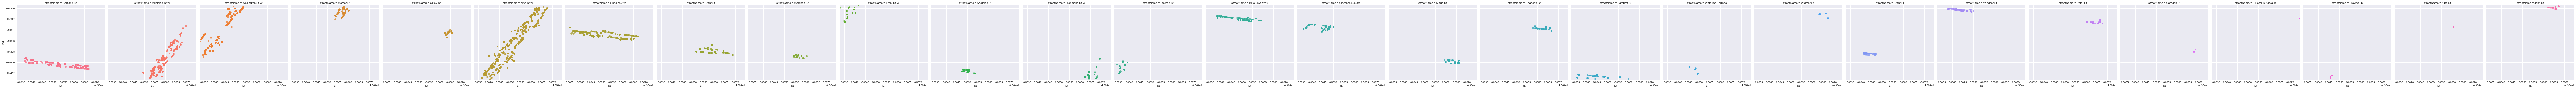

In [4]:
chart = sns.lmplot('lat', 'lng', data=raw_df, hue='streetName', col='streetName', fit_reg=False)
chart.set(xlim=(raw_df['lat'].min(), raw_df['lat'].max()))
chart.set(ylim=(raw_df['lng'].min(), raw_df['lng'].max()))
plt.show()

# Train the Model

In [5]:
def get_model():
    model = Sequential()
    model.add(Dense(60, input_dim=2, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(28, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

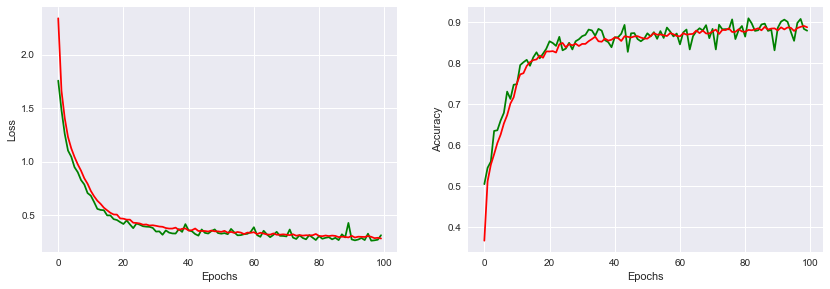

Accuracy: 87.99%


In [6]:
model = get_model()

training_data = model.fit(inputMatrix, target, validation_split=0.3, epochs=100, batch_size=10, verbose=False)

fig, axis = plt.subplots(1,2)
fig.set_size_inches(14, 4.5)
axis[0].plot(training_data.history['val_loss'], 'g', training_data.history['loss'], 'r')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[1].plot(training_data.history['val_acc'], 'g', training_data.history['acc'], 'r')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
plt.show()

print('Accuracy: %.2f%%' % (training_data.history['val_acc'][-1]*100))

# Visualize the Model

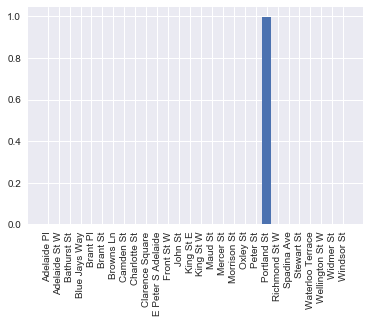

         lat        lng   streetName
0  43.645222 -79.400059  Portland St


In [7]:
input_index = 0;

predicted_match = model.predict(np.array([inputMatrix[input_index]]));

street_names = [name.replace('streetName_', '') for name in street_name_cols]

plt.bar(range(28), predicted_match[0])
plt.xticks(range(28), street_names, rotation='vertical')
#plt.yscale('log')
plt.show()

print(raw_df.iloc[[input_index]])

In [ ]:
map = Map(center=[raw_df.lat.mean(), raw_df.lng.mean()], zoom=17)

for index, input_row in enumerate(inputMatrix):
    predicted_match_scores = list(model.predict(np.array([input_row]))[0])
    predicted_street_index = predicted_match_scores.index(max(predicted_match_scores))
    predicted_street_name = street_names[predicted_street_index]
    
    raw_row = raw_df.loc[index]
    addPoint(map, lat=raw_row.lat, lng=raw_row.lng, street_name=raw_row.streetName, predicted_street_name=predicted_street_name)

map

![street-by-address-input](img/street-by-address-output.png)